Add Bullpen to Model

    - In the last notebook we augmented our dataframe to include various features based on the starting pitcher's performance
    - Now we will add these features in to see how much improvement we get to our model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [2]:
df=pd.read_csv('df_bp7.csv', low_memory=False)

BEGIN MODELING

In [3]:
df = df[df.run_diff!=0]
df_train = df[(df.season>1980) & (df.season<=2018) & ~(df.OBP_162_h.isnull())]
df_valid = df[(df.season>=2019) & (df.season<=2020)]
df_test = df[df.season>=2021]

In [4]:
df.shape

(59223, 611)

In [5]:
hv_mean = df_train.home_victory.mean()

In [6]:
np.array(df.columns)

array(['date', 'dblheader_code', 'day_of_week', 'team_v', 'league_v',
       'game_no_v', 'team_h', 'league_h', 'game_no_h', 'runs_v', 'runs_h',
       'outs_total', 'day_night', 'completion_info', 'forfeit_info',
       'protest_info', 'ballpark_id', 'attendance', 'game_minutes',
       'linescore_v', 'linescore_h', 'AB_v', 'H_v', '2B_v', '3B_v',
       'HR_v', 'RBI_v', 'SH_v', 'SF_v', 'HBP_v', 'BB_v', 'IBB_v', 'SO_v',
       'SB_v', 'CS_v', 'GIDP_v', 'CI_v', 'LOB_v', 'P_num_v', 'ERind_v',
       'ERteam_v', 'WP_v', 'balk_v', 'PO_v', 'ASST_v', 'ERR_v', 'PB_v',
       'DP_v', 'TP_v', 'AB_h', 'H_h', '2B_h', '3B_h', 'HR_h', 'RBI_h',
       'SH_h', 'SF_h', 'HBP_h', 'BB_h', 'IBB_h', 'SO_h', 'SB_h', 'CS_h',
       'GIDP_h', 'CI_h', 'LOB_h', 'P_num_h', 'ERind_h', 'ERteam_h',
       'WP_h', 'balk_h', 'PO_h', 'ASST_h', 'ERR_h', 'PB_h', 'DP_h',
       'TP_h', 'ump_HB_id', 'ump_HB_name', 'ump_1B_id', 'ump_1B_name',
       'ump_2B_id', 'ump_2B_name', 'ump_3B_id', 'ump_3B_name',
       'ump_LF_id'

Let's add in some basic bullpen features

In [7]:
target = 'home_victory'

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [8]:
def try_features(feat_set, max_depth=2):
    target = 'home_victory'
    X_train = df_train.loc[:,feat_set]
    X_valid = df_valid.loc[:,feat_set]
    X_test = df_test.loc[:,feat_set]



    lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=max_depth)
    lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50)])
    
    preds_lgbm_test = lgbm1.predict_proba(X_test)[:,1]
    ll_test = log_loss(y_test, preds_lgbm_test)

    print(f'\nVegas probs: {log_loss(y_test,df_test.implied_prob_h_mid)} on test')
    print(f'model probs: {ll_test} on test')

    print(f'\nDifference: {ll_test - log_loss(y_test,df_test.implied_prob_h_mid)} on test')

    sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
    sv_lgbm = pd.DataFrame(sv_lgbm)
    sv_lgbm.columns = list(X_test.columns)+['Intercept']
    sv_vec = sv_lgbm.abs().mean().sort_values(ascending=False)
    print('\nAvg Shap Vals')
    
    print(sv_vec)
    out_dict={}
    out_dict['ll_test'] = ll_test
    out_dict['model'] = lgbm1
    out_dict['shap_val_avgs'] = sv_vec
    out_dict['preds_test'] = preds_lgbm_test
    return(out_dict)

In [9]:
features1 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            ]

In [10]:
d1 = try_features(features1)

[LightGBM] [Info] Number of positive: 17723, number of negative: 14869
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 32592, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.543784 -> initscore=0.175585
[LightGBM] [Info] Start training from score 0.175585
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[308]	valid_0's binary_logloss: 0.680769

Vegas probs: 0.6749355876000072 on test
model probs: 0.6816726405311359 on test

Difference: 0.006737052931128695 on test

Avg Shap Vals
Intercept               0.177668
Strt_SO_perc_10_v       0.070231
Strt_TB_BB_perc_35_h    0.069454
OBP_162_h               0.064187
OBP_162_v               0.062836
Strt_SO_perc_10_h       0.060266
Strt_TB_BB_perc_35_v    0.054271

In [11]:
features2 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
            ]

In [12]:
d2 = try_features(features2)

[LightGBM] [Info] Number of positive: 17723, number of negative: 14869
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 32592, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.543784 -> initscore=0.175585
[LightGBM] [Info] Start training from score 0.175585
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[432]	valid_0's binary_logloss: 0.678575

Vegas probs: 0.6749355876000072 on test
model probs: 0.6808563255846649 on test

Difference: 0.0059207379846577535 on test

Avg Shap Vals
Intercept               0.178056
Strt_SO_perc_10_v       0.074783
Strt_TB_BB_perc_35_h    0.067851
Strt_SO_perc_10_h       0.066152
OBP_162_h               0.058049
OBP_162_v               0.054483
Strt_TB_BB_perc_35_v    0.05233

In [13]:
features3 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_75_h','Bpen_WHIP_75_v',
            'Bpen_TB_BB_perc_75_h', 'Bpen_TB_BB_perc_75_v',
            'Bpen_H_BB_perc_75_h', 'Bpen_H_BB_perc_75_v',
            'Bpen_SO_perc_75_h', 'Bpen_SO_perc_75_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v',
            ]

In [14]:
d3 = try_features(features3, max_depth=2)

[LightGBM] [Info] Number of positive: 17723, number of negative: 14869
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9180
[LightGBM] [Info] Number of data points in the train set: 32592, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.543784 -> initscore=0.175585
[LightGBM] [Info] Start training from score 0.175585
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[614]	valid_0's binary_logloss: 0.676864

Vegas probs: 0.6749355876000072 on test
model probs: 0.680321626470863 on test

Difference: 0.005386038870855869 on test

Avg Shap Vals
Intercept               0.178488
Strt_SO_perc_10_v       0.076904
Strt_SO_perc_10_h       0.071719
Strt_TB_BB_perc_35_h    0.067897
OBP_162_h               0.056421
Strt_TB_BB_perc_35_v    0.055835
OBP_162_v               0.053681


In [15]:
features4 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_75_h','Strt_WHIP_75_v',
            'Strt_TB_BB_perc_75_h', 'Strt_TB_BB_perc_75_v',
            'Strt_H_BB_perc_75_h', 'Strt_H_BB_perc_75_v',
            'Strt_SO_perc_75_h', 'Strt_SO_perc_75_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_35_h', 'Strt_SO_perc_35_v',
            'Strt_WHIP_10_h','Strt_WHIP_10_v',
            'Strt_TB_BB_perc_10_h', 'Strt_TB_BB_perc_10_v',
            'Strt_H_BB_perc_10_h', 'Strt_H_BB_perc_10_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_75_h','Bpen_WHIP_75_v',
            'Bpen_TB_BB_perc_75_h', 'Bpen_TB_BB_perc_75_v',
            'Bpen_H_BB_perc_75_h', 'Bpen_H_BB_perc_75_v',
            'Bpen_SO_perc_75_h', 'Bpen_SO_perc_75_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v',
            ]

In [16]:
d4 = try_features(features4)

[LightGBM] [Info] Number of positive: 17723, number of negative: 14869
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 32592, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.543784 -> initscore=0.175585
[LightGBM] [Info] Start training from score 0.175585
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[554]	valid_0's binary_logloss: 0.677144

Vegas probs: 0.6749355876000072 on test
model probs: 0.6799402242786696 on test

Difference: 0.005004636678662466 on test

Avg Shap Vals
Intercept               0.178388
Strt_TB_BB_perc_35_h    0.058218
OBP_162_h               0.053401
Strt_SO_perc_10_v       0.050208
OBP_162_v               0.048788
Strt_SO_perc_10_h       0.047626
Bpen_SO_perc_35_h       0.03828

In [17]:
features5 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
             'ERR_162_h', 'ERR_162_v',
             'SB_162_h', 'SB_162_v',
             'CS_162_h', 'CS_162_v',
             
             
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_75_h','Bpen_WHIP_75_v',
            'Bpen_TB_BB_perc_75_h', 'Bpen_TB_BB_perc_75_v',
            'Bpen_H_BB_perc_75_h', 'Bpen_H_BB_perc_75_v',
            'Bpen_SO_perc_75_h', 'Bpen_SO_perc_75_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v',
            ]

In [18]:
d5 = try_features(features5)

[LightGBM] [Info] Number of positive: 17723, number of negative: 14869
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10196
[LightGBM] [Info] Number of data points in the train set: 32592, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.543784 -> initscore=0.175585
[LightGBM] [Info] Start training from score 0.175585
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[804]	valid_0's binary_logloss: 0.677188

Vegas probs: 0.6749355876000072 on test
model probs: 0.6802330587684834 on test

Difference: 0.005297471168476231 on test

Avg Shap Vals
Intercept               0.178805
Strt_SO_perc_10_v       0.080140
Strt_SO_perc_10_h       0.075249
Strt_TB_BB_perc_35_h    0.068951
OBP_162_h             

In [19]:
rd = mli.get_range_dict(df_train)
plot_pts = df_test.loc[:,features5].sample(1, random_state=42)

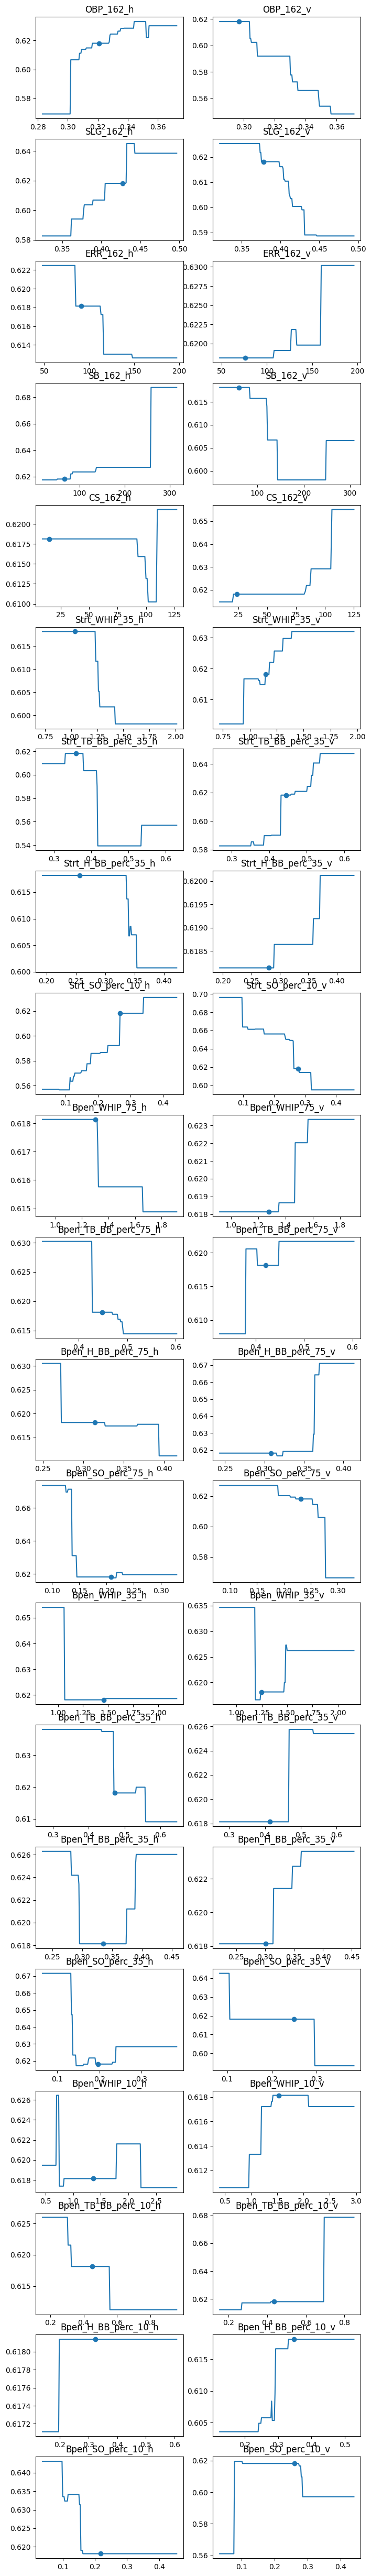

In [20]:
mli.ice_plot(d5['model'], plot_pts, features5, rd, plots_per_row=2)

In [21]:
df['SBadj_162_h'] = df['SB_162_h'] - 3*df['CS_162_h']
df['SBadj_162_v'] = df['SB_162_v'] - 3*df['CS_162_v']

In [22]:
df_train = df[(df.season>1901) & (df.season<=2015) & ~(df.OBP_162_h.isnull())]
df_valid = df[(df.season>=2016) & (df.season<=2020)]
df_test = df[df.season>=2021]
df_test_val = df[df.season>=2019]

In [ ]:
len(df.OBP_162_h)

In [23]:
features6  = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
             'ERR_162_h', 'ERR_162_v',
             # 'SB_162_h', 'SB_162_v',
             # 'CS_162_h', 'CS_162_v',
             'SBadj_162_h','SBadj_162_v',
             
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_75_h','Bpen_WHIP_75_v',
            'Bpen_TB_BB_perc_75_h', 'Bpen_TB_BB_perc_75_v',
            'Bpen_H_BB_perc_75_h', 'Bpen_H_BB_perc_75_v',
            'Bpen_SO_perc_75_h', 'Bpen_SO_perc_75_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v',
            ]


In [24]:
d6 = try_features(features6)


[LightGBM] [Fatal] Length of label is not same with #data


LightGBMError: Length of label is not same with #data

In [ ]:

len(features6)

Let's analyze model 3

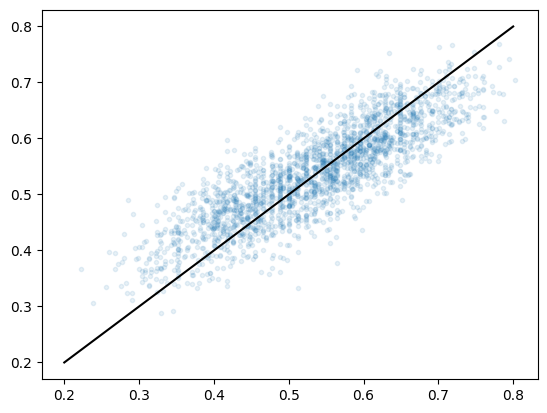

In [25]:
plt.scatter(df_test.implied_prob_h_mid, d3['preds_test'], marker='.', alpha=.1)
plt.plot([.2,.8],[.2,.8], color='k')

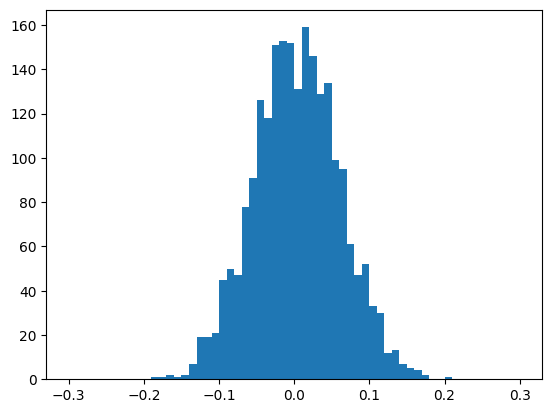

In [26]:
test_disc = d3['preds_test'] - df_test.implied_prob_h_mid
plt.hist(test_disc, bins=np.linspace(-.3,.3,61));

In [27]:
## let's compare performance on the cases with a large discrepancy
mask = (np.abs(test_disc))>.1
log_loss(y_test[mask], d3['preds_test'][mask]), log_loss(y_test[mask], df_test.implied_prob_h_mid[mask])

(0.6798553016893388, 0.6308393352015492)

In [28]:
log_loss(y_test[~mask], d3['preds_test'][~mask]), log_loss(y_test[~mask], df_test.implied_prob_h_mid[~mask])

(0.680362294329717, 0.6787811910068494)

Conclusions
    - Still about 40 bps away from Vegas probabilities (down from ~70)
    - When our model and Vegas "disagree", Vegas is generally right!

    - We are running out of "big wins"
    - Features based on actual starting lineup
    - Fielding
    - Lefty vs Righty analysis

Next Steps

    - Get individual batter data
    - Make features based on the actual lineup
    - Analyze runs scored (over/under)
    - Perhaps the model for runs scored will help with the moneyline model